In [111]:
import pandas as pd

from features import Featured

people = pd.read_csv("../datasets/brazilian_names.csv")

df = pd.DataFrame(
    [Featured.from_dict(*row.values()) for row in people.to_dict(orient="records")]
)

AttributeError: type object 'Featured' has no attribute 'from_dict'

In [ ]:
# plano de emergência: explodir coluna de sílabas normalizadas e gerar decisões a partir delas
exploded_sylables = df.explode("normalized_syllables", ignore_index=True).rename(
    columns={"normalized_syllables": "syllable"}
).drop(columns=["syllables"])
exploded_sylables.head()

,original,syllable,ends_in_vowel,ending_vowel,ending_consonant,nasal_count,sharp_count,a_count,i_count,u_count,e_count,o_count,rome_r_count,potato_r_count,laughed_r_count,gender
0,jose,jo,True,e,None,1,0,0,0,0,1,1,0,0,0,M
1,jose,se,True,e,None,1,0,0,0,0,1,1,0,0,0,M
2,chie,chi,True,e,None,0,1,0,1,0,1,0,0,0,0,F
3,chie,e,True,e,None,0,1,0,1,0,1,0,0,0,0,F
4,fernando,fer,True,o,None,1,0,1,0,0,1,1,0,1,0,M


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
hot_ending_vowel_arr = encoder.fit_transform(df[["ending_vowel"]])
hot_ending_vowel_df = pd.DataFrame(hot_ending_vowel_arr, columns=encoder.get_feature_names_out(["ending_vowel"])).astype(bool)

df = pd.concat([df, hot_ending_vowel_df], axis=1)
hot_ending_vowel_df.head(10)

,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,False,False,True,False,False
3,False,False,False,True,False,False
4,False,True,False,False,False,False
5,False,True,False,False,False,False
6,False,False,True,False,False,False
7,False,False,True,False,False,False
8,True,False,False,False,False,False
9,True,False,False,False,False,False


In [ ]:
# feature para caracteres e fonemas estrangeiros? ki, sh, y
df.loc[(df["gender"] == "F") & (df["ends_in_vowel"] == False)]

,original,syllables,normalized_syllables,ends_in_vowel,ending_vowel,ending_consonant,nasal_count,sharp_count,a_count,i_count,...,rome_r_count,potato_r_count,laughed_r_count,gender,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y
54,yasmin,"[Yas, min]","[yas, min]",False,i,n,0,0,1,1,...,0,0,0,F,False,False,True,False,False,False
91,beatriz,"[Be, a, triz]","[be, a, triz]",False,i,z,2,1,1,1,...,1,0,0,F,False,False,True,False,False,False


In [187]:
from typing import Any, Hashable


def partition(rows: pd.DataFrame, column: Hashable, breakpoint: Any) -> tuple[pd.DataFrame, pd.DataFrame]:
    if isinstance(breakpoint, int | float):
        groups = rows.groupby(rows[column].apply(lambda n: n >= breakpoint))
    else:
        groups = rows.groupby(rows[column].apply(lambda n: n == breakpoint))
    
    if groups.groups.get(False) is None:
        return groups.get_group(True), pd.DataFrame({column: []})
    if groups.groups.get(True) is None:
        return pd.DataFrame({column: []}), groups.get_group(False)

    return groups.get_group(True), groups.get_group(False)


def gini(rows: pd.DataFrame, target: str) -> float:
    return 1 - sum(rows[target].value_counts(normalize=True) ** 2)


def find_best_split(rows: pd.DataFrame, target: str) -> tuple[Hashable, Any]:
    best = (0, "", None) # gain, column, breakpoint
    uncertainty = gini(rows, target)

    for col, values in rows.items():
        if col == target:
            continue

        for val in values.unique():
            left, right = partition(rows, col, val)
            if len(left) == 0 or len(right) == 0:
                continue

            p = len(left) / (len(left) + len(right))
            gain = uncertainty - p * gini(left, target) - (1 - p) * gini(right, target)

            if gain > best[0]:
                best = (gain, col, val)

    return best[1], best[2]

In [189]:
test_df = df.drop(columns=["syllables", "normalized_syllables"])

split_col, split_break = find_best_split(test_df, "gender")
print(split_col, split_break)

ending_vowel a


In [193]:
left, right = partition(test_df, split_col, split_break)

left_split_col, left_split_break = find_best_split(left, "gender")
right_split_col, right_split_break = find_best_split(right, "gender")

In [194]:
ends_in_a___ends_in_vowel, ends_in_a___ends_in_consonant = partition(left, left_split_col, left_split_break)
doesnt_end_in_a___nasal_gte_1, doesnt_end_in_a___nasal_lt_1 = partition(right, right_split_col, right_split_break)

In [202]:
ends_in_a___ends_in_vowel['leaf_bin'] = 'A+vowel'
ends_in_a___ends_in_consonant['leaf_bin'] = 'A+consonant'
doesnt_end_in_a___nasal_gte_1['leaf_bin'] = '!A+nasal'
doesnt_end_in_a___nasal_lt_1['leaf_bin'] = '!A+!nasal'

df_all = pd.concat([ends_in_a___ends_in_vowel, ends_in_a___ends_in_consonant, doesnt_end_in_a___nasal_gte_1, doesnt_end_in_a___nasal_lt_1], ignore_index=True)

/tmp/ipykernel_126972/4045168318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ends_in_a___ends_in_vowel['leaf_bin'] = 'A+vowel'
/tmp/ipykernel_126972/4045168318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ends_in_a___ends_in_consonant['leaf_bin'] = 'A+consonant'
/tmp/ipykernel_126972/4045168318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

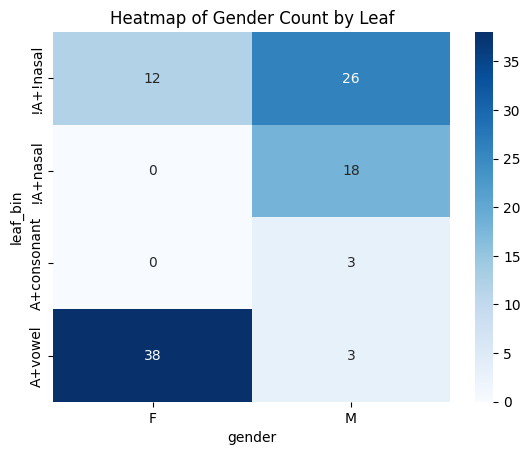

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns


pivot = df_all.pivot_table(index='leaf_bin', columns='gender', aggfunc='size', fill_value=0)
sns.heatmap(pivot, annot=True, cmap='Blues')
plt.title("Heatmap of Gender Count by Leaf")
plt.show()

In [161]:
df.groupby(df["gender"].apply(lambda s: s == "F")).all()

,original,syllables,normalized_syllables,ends_in_vowel,ending_vowel,ending_consonant,nasal_count,sharp_count,a_count,i_count,...,rome_r_count,potato_r_count,laughed_r_count,gender,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y
gender,,,,,,,,,,,,,,,,,,,,,
False,True,True,True,False,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
True,True,True,True,False,True,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
from dataclasses import dataclass
from typing import Self


@dataclass
class Leaf:
    category: str


@dataclass
class Decision:
    rows: pd.DataFrame
    target: str

    column: str
    breakpoint: Any

    left: Self | Leaf
    right: Self | Leaf

    @classmethod
    def build_branch(cls, rows: pd.DataFrame, target: str) -> Self:
        col, brkpt = find_best_split(rows, target)

        if isinstance(brkpt, int | float):
            (_, left), (_, right) = rows.groupby(rows[col].apply(lambda n: n >= brkpt))
        else:
            (_, left), (_, right) = rows.groupby(rows[col].apply(lambda n: n == brkpt))

        return cls(
            rows,
            target,
            col,
            brkpt,
            Decision.build_branch(left, target),
            Decision.build_branch(right, target),
        )

/home/jorge/Área de trabalho/decision-tree-names-br/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 27.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jorge/Área de trabalho/decision-tree-names-br/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 44.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jorge/Área de trabalho/decision-tree-names-br/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 44.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jorge/Área de trabalho/decision-tree-names-br/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 58.6% of the points cannot be placed; you may want to decrease the 

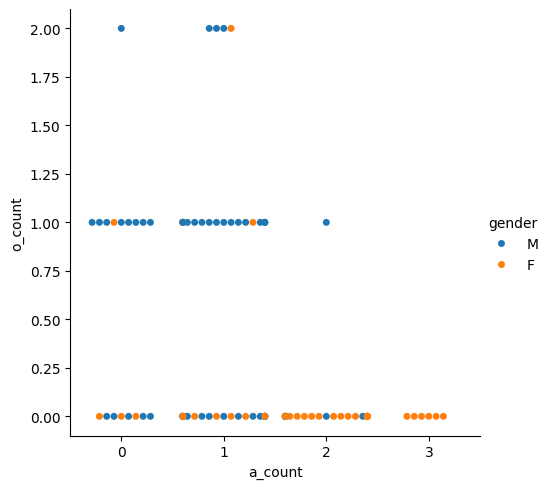

In [62]:
import seaborn as sns
sns.catplot(data=df, x="a_count", y="o_count", hue="gender", kind="swarm",)

In [54]:
print(len(df.loc[(df["o_count"] == 0) & (df["gender"] == "F")]))
print(len(df.loc[(df["o_count"] == 0) & (df["gender"] == "M")]))
df.loc[(df["o_count"] > 1) & (df["gender"] == "F")]

46
21


,original,syllables,normalized_syllables,ends_in_vowel,ending_vowel,ending_consonant,nasal_count,sharp_count,a_count,i_count,...,rome_r_count,potato_r_count,laughed_r_count,gender,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y
39,naoko,"[Nao, ko]","[nao, ko]",True,o,None,0,1,1,0,...,0,0,0,F,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
print(len(df.loc[(df["a_count"] == 1) & (df["gender"] == "F")]))
print(len(df.loc[(df["a_count"] == 1) & (df["gender"] == "M")]))

16
31


In [ ]:
decision_tree = {
    "o_count == 0?": {
        ""
    }
}